In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ls ('/content/drive/MyDrive/kilterboard_data/')

Mounted at /content/drive
/bin/bash: -c: line 1: syntax error near unexpected token `'/content/drive/MyDrive/kilterboard_data/''
/bin/bash: -c: line 1: `ls ('/content/drive/MyDrive/kilterboard_data/')'


In [ ]:
climbs = pd.read_csv('/content/drive/MyDrive/kilterboard_data/full_clean_dataset.csv')

In [ ]:
import ast

In [ ]:
type(climbs[0:1].placements)

pandas.core.series.Series

In [ ]:
for hold in climbs[0:1].placements:
  print(hold)

[{'x': 20, 'y': 0, 'type': 'FEET-ONLY', 'ledPosition': 15}, {'x': 8, 'y': 3, 'type': 'FEET-ONLY', 'ledPosition': 143}, {'x': 16, 'y': 5, 'type': 'START', 'ledPosition': 244}, {'x': 12, 'y': 7, 'type': 'START', 'ledPosition': 191}, {'x': 14, 'y': 9, 'type': 'MIDDLE', 'ledPosition': 203}, {'x': 22, 'y': 13, 'type': 'MIDDLE', 'ledPosition': 308}, {'x': 8, 'y': 19, 'type': 'MIDDLE', 'ledPosition': 131}, {'x': 16, 'y': 19, 'type': 'MIDDLE', 'ledPosition': 233}, {'x': 12, 'y': 23, 'type': 'MIDDLE', 'ledPosition': 179}, {'x': 8, 'y': 29, 'type': 'MIDDLE', 'ledPosition': 124}, {'x': 14, 'y': 31, 'type': 'MIDDLE', 'ledPosition': 219}, {'x': 14, 'y': 35, 'type': 'FINISH', 'ledPosition': 221}]


In [ ]:
# Helper functions

def difficulty_to_vgrade(difficulty):
    """Convert Kilter Board difficulty_average to V-grade with a refined scale"""
    if difficulty is None or pd.isna(difficulty):
        return "N/A"

    # Detailed conversion
    if difficulty < 8:
        return "VB"
    elif difficulty < 10:
        return "V0"
    elif difficulty < 12:
        return "V1"
    elif difficulty < 14:
        return "V2"
    elif difficulty < 16:
        return "V3"
    elif difficulty < 18:
        return "V4"
    elif difficulty < 20:
        return "V5"
    elif difficulty < 22:
        return "V6"
    elif difficulty < 24:
        return "V7"
    elif difficulty < 26:
        return "V8"
    elif difficulty < 28:
        return "V9"
    elif difficulty < 30:
        return "V10"
    elif difficulty < 32:
        return "V11"
    elif difficulty < 34:
        return "V12"
    elif difficulty < 36:
        return "V13"
    elif difficulty < 38:
        return "V14"
    elif difficulty < 40:
        return "V15"
    else:
        return "V16+"

In [ ]:
def create_train_test_split(df, test_size=0.2, random_state=42):
    """
    Create train and test sets for machine learning while ensuring that all entries
    with the same 'name' are always in the same set to prevent data leakage.

    Parameters:
    -----------
    df : pandas.DataFrame
        The DataFrame containing the boulder data with angle-specific entries
    test_size : float, optional
        The proportion of the dataset to include in the test split (default: 0.2)
    random_state : int, optional
        Controls the shuffling applied to the data (default: 42)

    Returns:
    --------
    tuple
        (X_train, X_test, y_train, y_test) - Features and target variables for training and testing
    """
    import numpy as np
    from sklearn.model_selection import train_test_split

    # Get unique boulder names
    unique_names = df['name'].unique()

    # Randomly select boulder names for train and test sets
    np.random.seed(random_state)
    test_names = np.random.choice(
        unique_names,
        size=int(len(unique_names) * test_size),
        replace=False
    )

    # Create masks for the splits
    test_mask = df['name'].isin(test_names)
    train_mask = ~test_mask

    # Split the data
    train_df = df[train_mask]
    test_df = df[test_mask]

    # Print split information
    print(f"Total dataset size: {len(df)} entries ({len(unique_names)} unique boulder problems)")
    print(f"Training set: {len(train_df)} entries ({train_df['name'].nunique()} unique boulder problems)")
    print(f"Test set: {len(test_df)} entries ({test_df['name'].nunique()} unique boulder problems)")

    # Check if the split matches the desired ratio approximately
    actual_test_size = len(test_df) / len(df)
    print(f"Requested test size: {test_size:.1%}, Actual test size: {actual_test_size:.1%}")

    # Assume 'grade' is the target variable - adjust if needed
    X_train = train_df.drop('grade', axis=1)
    y_train = train_df['grade']
    X_test = test_df.drop('grade', axis=1)
    y_test = test_df['grade']

    return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = create_train_test_split(climbs)

Total dataset size: 19272 entries (12028 unique boulder problems)
Training set: 15306 entries (9623 unique boulder problems)
Test set: 3966 entries (2405 unique boulder problems)
Requested test size: 20.0%, Actual test size: 20.6%


In [ ]:
def create_cnn_model(df, X_train, X_test, y_train, y_test):
    """
    Create and train an improved CNN model to predict boulder grades using LED positions.

    Parameters:
    -----------
    df : pandas.DataFrame
        The original DataFrame with all data
    X_train, X_test, y_train, y_test : pandas.DataFrame/Series
        Train/test split data

    Returns:
    --------
    tuple
        (model, history, evaluation_metrics)
    """
    import numpy as np
    import tensorflow as tf
    from tensorflow.keras import layers, models
    from sklearn.preprocessing import StandardScaler
    import ast


    # encode hold types (basically count and add as numerical feature)
    def encode_hold_types(placements_str):
        """Create new feature encoding the number of each hold type"""
        try:
            placements = ast.literal_eval(placements_str) if isinstance(placements_str, str) else placements_str

            # Count different hold types
            start_holds = sum(1 for hold in placements if hold.get('type') == 'START')
            middle_holds = sum(1 for hold in placements if hold.get('type') == 'MIDDLE')
            finish_holds = sum(1 for hold in placements if hold.get('type') == 'FINISH')
            feet_only = sum(1 for hold in placements if hold.get('type') == 'FEET-ONLY')

            return [start_holds, middle_holds, finish_holds, feet_only]
        except:
            return [0, 0, 0, 0]


    # create a multi-channel representation of the board
    def create_multichannel_grid(placements_str, grid_width=24, grid_height=18):
        """
        Create a multi-channel 2D grid representing different hold types (24,18,4)
        """
        # Initialize empty grid with 4 channels (START, MIDDLE, FINISH, FEET-ONLY)
        grid = np.zeros((grid_height, grid_width, 4))

        try:
            # Parse placements
            placements = ast.literal_eval(placements_str) if isinstance(placements_str, str) else placements_str

            # Channel mappings
            type_to_channel = {
                'START': 0,
                'MIDDLE': 1,
                'FINISH': 2,
                'FEET-ONLY': 3
            }

            # Fill grid with hold placements
            for hold in placements:
                x = hold.get('x', 0)
                y = hold.get('y', 0)

                # Normalize to grid indices
                x_idx = min(int(x * (grid_width - 1) / 24), grid_width - 1)
                y_idx = min(int(y * (grid_height - 1) / 36), grid_height - 1)

                # Get hold type and map to channel
                hold_type = hold.get('type', '')
                channel = type_to_channel.get(hold_type, 1)  # Default to MIDDLE

                # Mark hold position in appropriate channel
                grid[y_idx, x_idx, channel] = 1

            return grid
        except:
            return np.zeros((grid_height, grid_width, 4))

    # Process features
    # Create both standard grid and multichannel grid
    feature_cols = ['angle', 'hold_count', 'ascents']
    scaler = StandardScaler()

    # Normalize numerical features
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()

    #scale numerical features to put them all on the same scale (standardization)
    X_train_scaled[feature_cols] = scaler.fit_transform(X_train[feature_cols])
    #use SAME parameters for standardization on test data
    X_test_scaled[feature_cols] = scaler.transform(X_test[feature_cols])

    # Create multichannel grids from placements
    train_grids = np.array([create_multichannel_grid(p) for p in X_train['placements']])
    test_grids = np.array([create_multichannel_grid(p) for p in X_test['placements']])

    # Create hold type encodings
    train_hold_types = np.array([encode_hold_types(p) for p in X_train['placements']])
    test_hold_types = np.array([encode_hold_types(p) for p in X_test['placements']])

    # Create input for numerical features
    train_features = np.array(X_train_scaled[feature_cols])
    test_features = np.array(X_test_scaled[feature_cols])

    # Combine with hold type encodings
    train_features = np.hstack((train_features, train_hold_types))
    test_features = np.hstack((test_features, test_hold_types))

    # Build the CNN model with both image and numerical inputs
    # Input for the grid
    grid_input = layers.Input(shape=train_grids.shape[1:])

    # CNN layers for the grid
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(grid_input)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)

    # Input for numerical features
    numerical_input = layers.Input(shape=(len(feature_cols) + 4,))  # +4 for hold type encodings

    # Dense layers for numerical features
    y = layers.Dense(32, activation='relu')(numerical_input)

    # Combine the CNN output with numerical features
    combined = layers.concatenate([x, y])

    # Dense layers for combined data
    z = layers.Dense(256, activation='relu')(combined)
    z = layers.Dropout(0.3)(z)
    z = layers.Dense(128, activation='relu')(z)
    z = layers.Dropout(0.3)(z)
    z = layers.Dense(64, activation='relu')(z)
    z = layers.Dropout(0.2)(z)

    # Output layer (predicting a single continuous value)
    output = layers.Dense(1)(z)

    # Create model
    model = models.Model(inputs=[grid_input, numerical_input], outputs=output)

    # Create Optimizer with learning rate schedule
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.001,
        decay_steps=1000,
        decay_rate=0.9)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    # Compile model
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error',
                  metrics=['mean_absolute_error'])

    # Display model summary
    model.summary()

    # Callbacks for early stopping and model checkpoint
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True)

    # Train the model
    history = model.fit(
        [train_grids, train_features],
        y_train,
        epochs=30,
        batch_size=32,
        validation_split=0.2,
        verbose=1,
        callbacks=[early_stopping]
    )

    # Evaluate on test set
    test_results = model.evaluate(
        [test_grids, test_features],
        y_test,
        verbose=1
    )

    # Make predictions
    predictions = model.predict([test_grids, test_features])

    # Calculate additional metrics
    from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)

    print("\nModel Evaluation:")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"Root Mean Squared Error: {rmse:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"R² Score: {r2:.4f}")

    # Convert predictions to V-grade scale for easier interpretation
    v_grade_predictions = [difficulty_to_vgrade(p[0]) for p in predictions]
    v_grade_actual = [difficulty_to_vgrade(g) for g in y_test]

    # Calculate accuracy in terms of exact V-grade matches
    exact_matches = sum(p == a for p, a in zip(v_grade_predictions, v_grade_actual))
    v_grade_accuracy = exact_matches / len(v_grade_predictions)

    print(f"V-grade Exact Match Accuracy: {v_grade_accuracy:.4f}")


    # Calculate accuracy within ±1 V-grade
    def v_grade_distance(v1, v2):
        """Calculate distance between V-grades"""
        v_scale = ["VB", "V0", "V1", "V2", "V3", "V4", "V5", "V6", "V7", "V8", "V9", "V10", "V11", "V12", "V13", "V14", "V15", "V16+"]
        if v1 not in v_scale or v2 not in v_scale:
            return float('inf')
        return abs(v_scale.index(v1) - v_scale.index(v2))

    within_one = sum(v_grade_distance(p, a) <= 1 for p, a in zip(v_grade_predictions, v_grade_actual))
    v_grade_accuracy_one = within_one / len(v_grade_predictions)

    print(f"V-grade ±1 Accuracy: {v_grade_accuracy_one:.4f}")


    # Create confusion matrix for V-grades
    def create_v_grade_confusion_matrix(actual, predicted):
        """Create and visualize confusion matrix for V-grades"""
        from sklearn.metrics import confusion_matrix
        import matplotlib.pyplot as plt
        import seaborn as sns

        v_scale = ["VB", "V0", "V1", "V2", "V3", "V4", "V5", "V6", "V7", "V8", "V9", "V10", "V11", "V12", "V13", "V14", "V15", "V16+"]

        # Filter to only include grades that appear in the data
        unique_grades = sorted(list(set(actual + predicted)), key=lambda x: v_scale.index(x) if x in v_scale else -1)

        # Create confusion matrix
        cm = confusion_matrix(
            [unique_grades.index(a) if a in unique_grades else -1 for a in actual],
            [unique_grades.index(p) if p in unique_grades else -1 for p in predicted],
            labels=range(len(unique_grades))
        )

        # Plot confusion matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=unique_grades,
                   yticklabels=unique_grades)
        plt.xlabel('Predicted Grade')
        plt.ylabel('Actual Grade')
        plt.title('V-Grade Confusion Matrix')
        plt.tight_layout()

        return cm

    # create confusion matrix
    try:
        cm = create_v_grade_confusion_matrix(v_grade_actual, v_grade_predictions)
        print("Confusion matrix generated successfully")
    except Exception as e:
        print(f"Could not generate confusion matrix: {e}")

    # Return model, history and metrics
    metrics = {
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'v_grade_accuracy': v_grade_accuracy,
        'v_grade_accuracy_one': v_grade_accuracy_one
    }

    return model, history, metrics

TensorFlow version: 2.18.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 18, 24, 4) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 18, 24,    │      1,184 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 9, 12, 32) │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 9, 12, 64) │     18,496 │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 4, 6, 64)  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 4, 6, 128) │     73,856 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 2, 3, 128) │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 7)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 768)       │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │        256 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 800)       │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    205,056 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     32,896 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      8,256 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │         65 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 340,065 (1.30 MB)

 Trainable params: 340,065 (1.30 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - loss: 62.6774 - mean_absolute_error: 5.9123 - val_loss: 11.1180 - val_mean_absolute_error: 2.6310
Epoch 2/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - loss: 14.2976 - mean_absolute_error: 3.0021 - val_loss: 10.5622 - val_mean_absolute_error: 2.5563
Epoch 3/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 21s 40ms/step - loss: 12.1414 - mean_absolute_error: 2.7386 - val_loss: 7.0339 - val_mean_absolute_error: 2.0287
Epoch 4/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - loss: 10.8004 - mean_absolute_error: 2.5901 - val_loss: 7.3889 - val_mean_absolute_error: 2.1157
Epoch 5/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - loss: 10.6719 - mean_absolute_error: 2.5519 - val_loss: 6.7210 - val_mean_absolute_error: 2.0086
Epoch 6/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - loss: 9.7093 - mean_absolute_error: 2.4599 - val_loss: 6.3144 - val_mean_absolute_error: 1.9410
Epoch 7/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - loss: 9.1433 - mean_absol

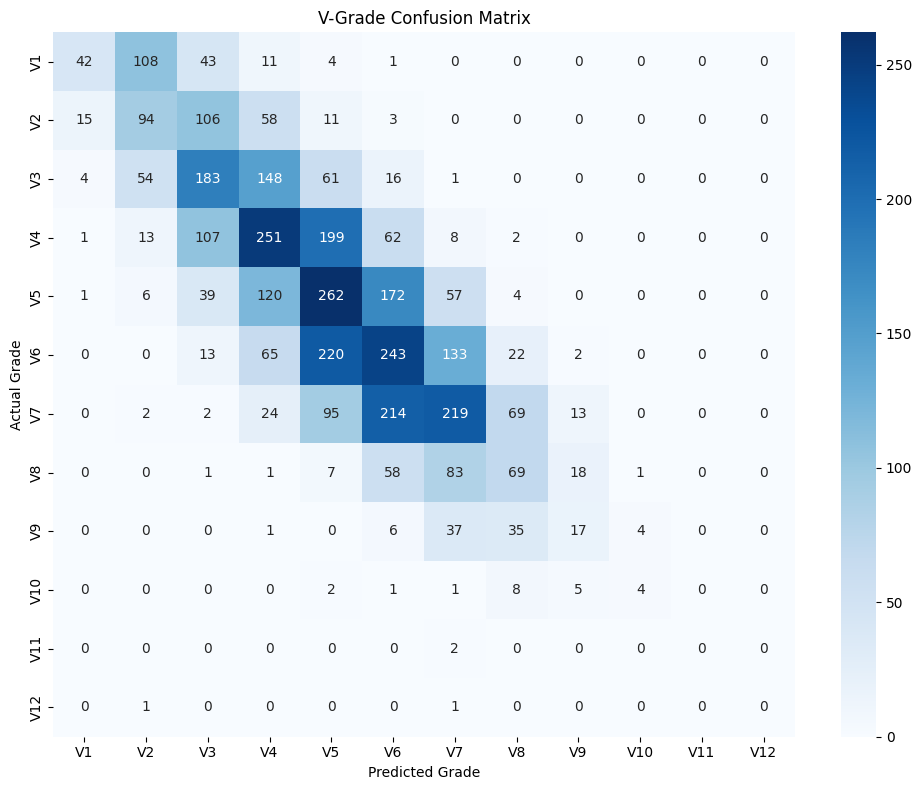

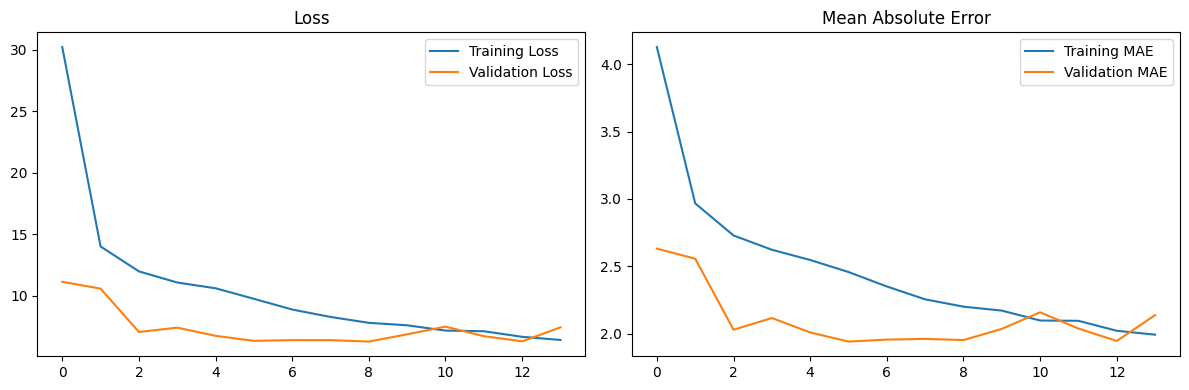

In [ ]:
import tensorflow as tf

# Check if TensorFlow is available
print(f"TensorFlow version: {tf.__version__}")

# Create and train the model
model, history, metrics = create_cnn_model(climbs, X_train, X_test, y_train, y_test)

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'], label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('Mean Absolute Error')
plt.legend()

plt.tight_layout()
plt.show()